In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import util

In [16]:
sns.set(rc={'figure.figsize': (16, 12), 'font.family': 'helvetica'})
sns.set(font_scale=1.35)
sns.set_style('whitegrid')
dirname = 'data/latency/'

In [17]:
def prep_data(measurements: list):
    arr = np.array([
        float(r['_2'] - r['_1'])
        for r in measurements
    ])
    arr /= 1_000_000
    return arr

In [18]:
exps = dict()

for filename in sorted(os.listdir(dirname)):
    with open(dirname + filename) as fp:
        data = json.load(fp)

    transport = 'kafka_' if filename.startswith('kafka') else 'grpc_'
    for key in data['result']['times']:
        key_parts = key.split(' ')
        if key_parts[-1] != '3':
            # Discard all but the last experiment in each group
            continue

        exps[(
            util.get_network_cond(data),
            transport + util.get_exp_name(data),
            ' '.join(key_parts[:2]),
            key_parts[2],
            util.get_ds_name(data),
        )] = prep_data(data['result']['times'][key])

In [19]:
s_exps = pd.DataFrame.from_dict(exps).unstack()

In [20]:
dt_exps = s_exps.reset_index().set_axis(['network', 'method', 'interval', 'mSize', 'dataset', 'n', 'latency'], axis=1, inplace=False)
dt_exps

,network,method,interval,mSize,dataset,n,latency
0,unlimited,grpc_jelly_full,100 microseconds,50,wikipedia,0,1.138113
1,unlimited,grpc_jelly_full,100 microseconds,50,wikipedia,1,0.613308
2,unlimited,grpc_jelly_full,100 microseconds,50,wikipedia,2,0.575607
3,unlimited,grpc_jelly_full,100 microseconds,50,wikipedia,3,0.529206
4,unlimited,grpc_jelly_full,100 microseconds,50,wikipedia,4,0.538606
...,...,...,...,...,...,...,...
1619995,50Mbit,kafka_n3_gzip,100 microseconds,5,flickr_10m,995,16.418833
1619996,50Mbit,kafka_n3_gzip,100 microseconds,5,flickr_10m,996,16.405833
1619997,50Mbit,kafka_n3_gzip,100 microseconds,5,flickr_10m,997,16.593436
1619998,50Mbit,kafka_n3_gzip,100 microseconds,5,flickr_10m,998,16.447833


<AxesSubplot:xlabel='mSize', ylabel='latency'>

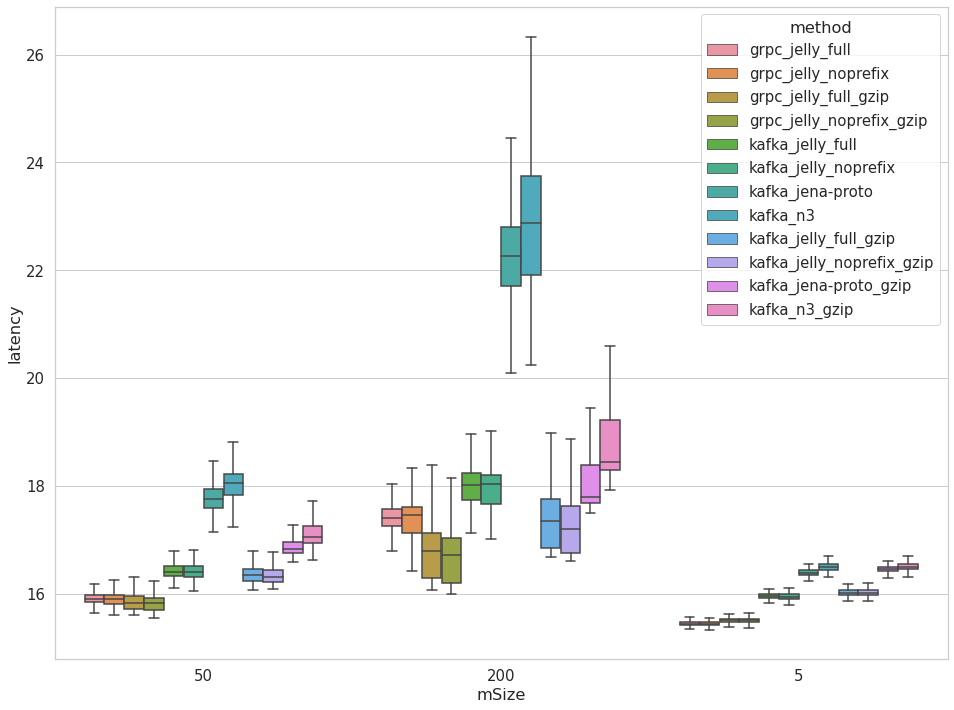

In [21]:
dt_x = dt_exps[(dt_exps.network == '50Mbit') & (dt_exps.interval == '100 microseconds')]\
    [['method', 'mSize', 'latency']]
sns.boxplot(data=dt_x, x='mSize', y='latency', hue='method', showfliers=False)

<Figure size 2160x1152 with 0 Axes>

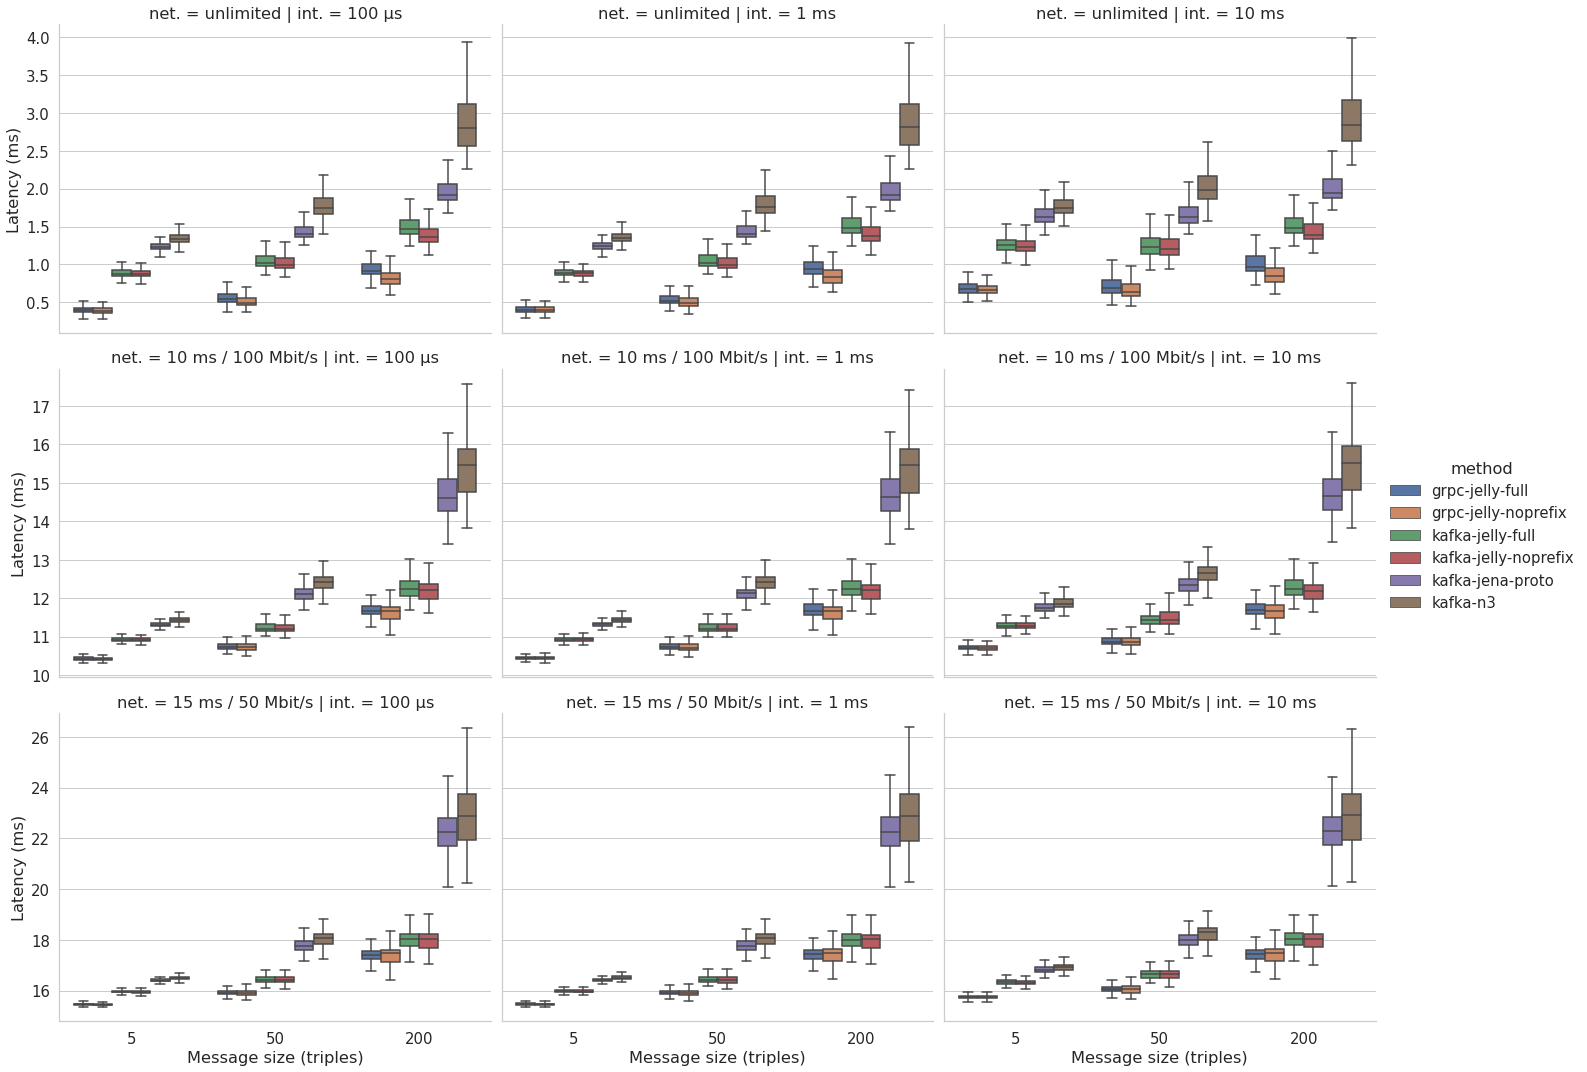

<Figure size 2160x1152 with 0 Axes>

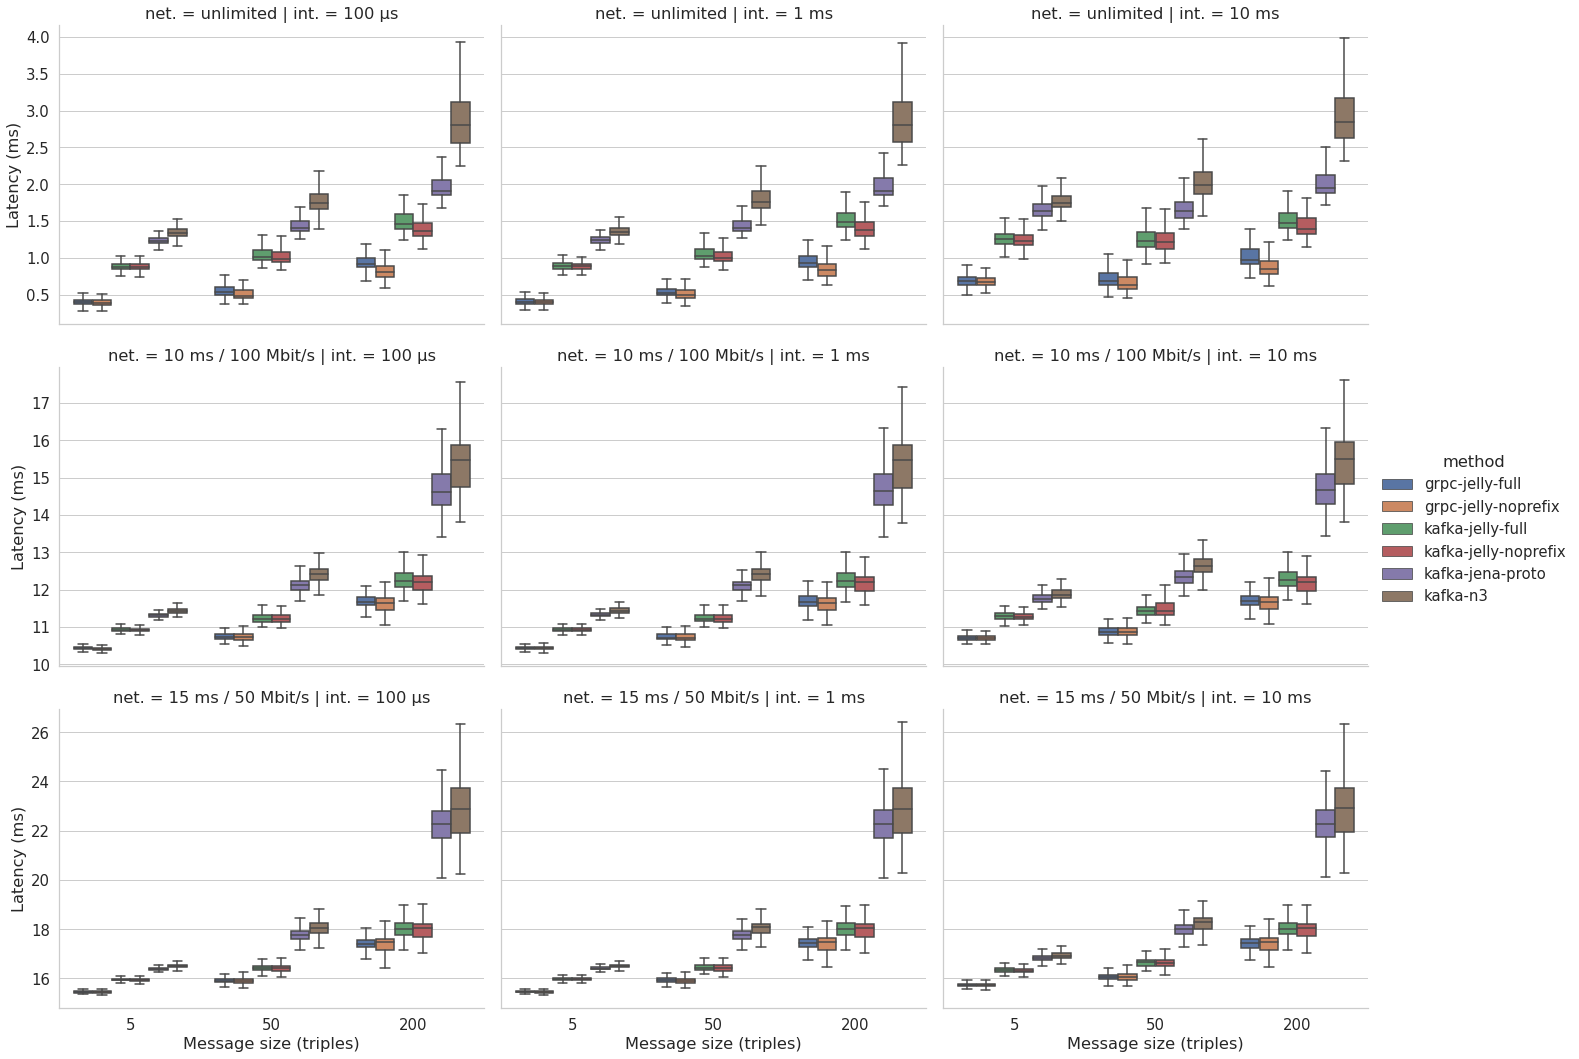

In [22]:
plt.figure(figsize=(30, 16))

dt_vis = dt_exps[~dt_exps.method.str.endswith('gzip')][['network', 'interval', 'method', 'mSize', 'latency']]

def short_times(long_form: str):
    if long_form == '10 milliseconds':
        return '10 ms'
    elif long_form == '1 millisecond':
        return '1 ms'
    return '100 μs'

dt_vis['interval'] = dt_vis['interval'].apply(lambda i: short_times(i))

def long_network(short_form: str):
    if short_form == '50Mbit':
        return '15 ms / 50 Mbit/s'
    elif short_form == '100Mbit':
        return '10 ms / 100 Mbit/s'
    return short_form

dt_vis['network'] = dt_vis['network'].apply(lambda n: long_network(n))
dt_vis['method'] = dt_vis['method'].apply(lambda n: n.replace('_', '-'))

dt_vis = dt_vis.rename(columns={'network': 'net.', 'interval': 'int.'})

g = sns.catplot(
    data=dt_vis, x='mSize', y='latency', hue='method',
    kind='box', row='net.', col='int.', showfliers=False,
    order=['5', '50', '200'],
    sharey='row', aspect=1.3
)

g.set_axis_labels('Message size (triples)', 'Latency (ms)')

plt.savefig('img/latency_catplot.svg')
plt.savefig('img/latency_catplot.eps')

<Figure size 720x720 with 0 Axes>

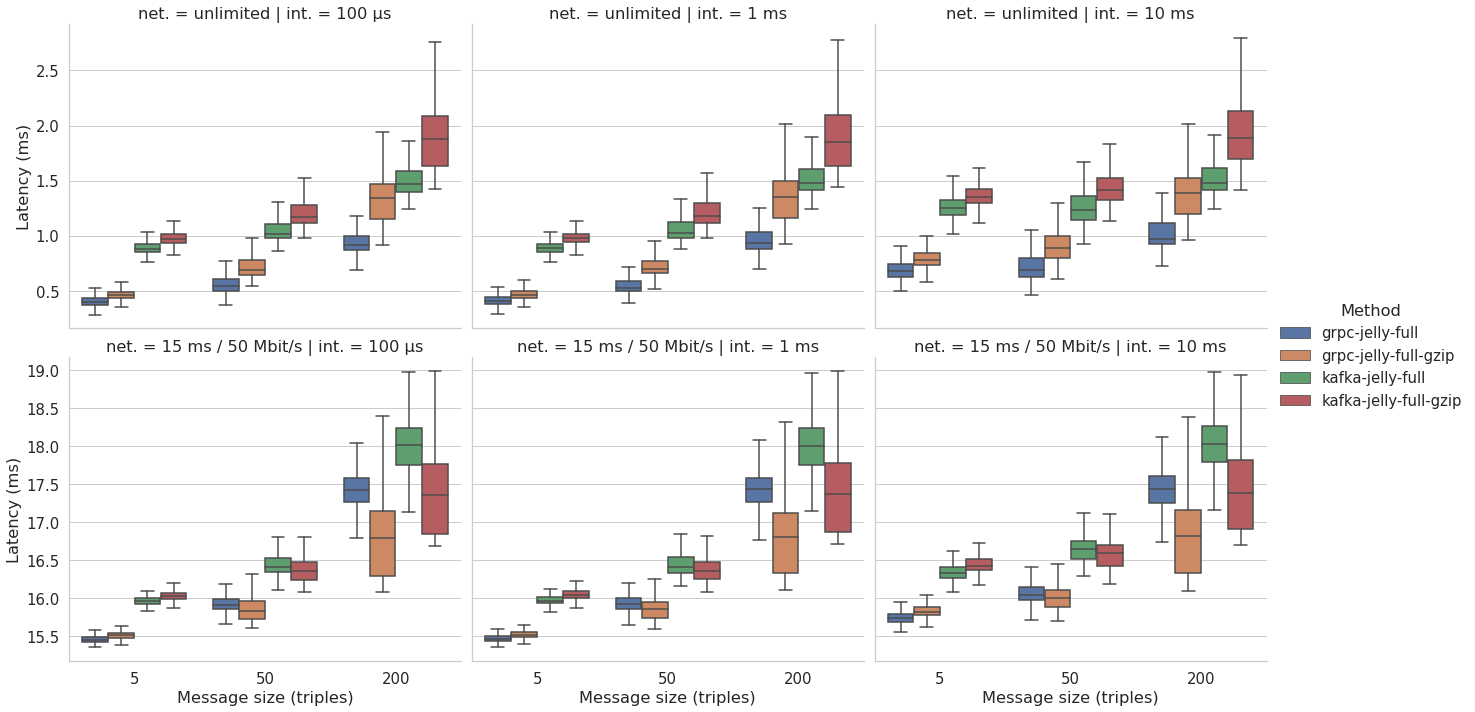

<Figure size 720x720 with 0 Axes>

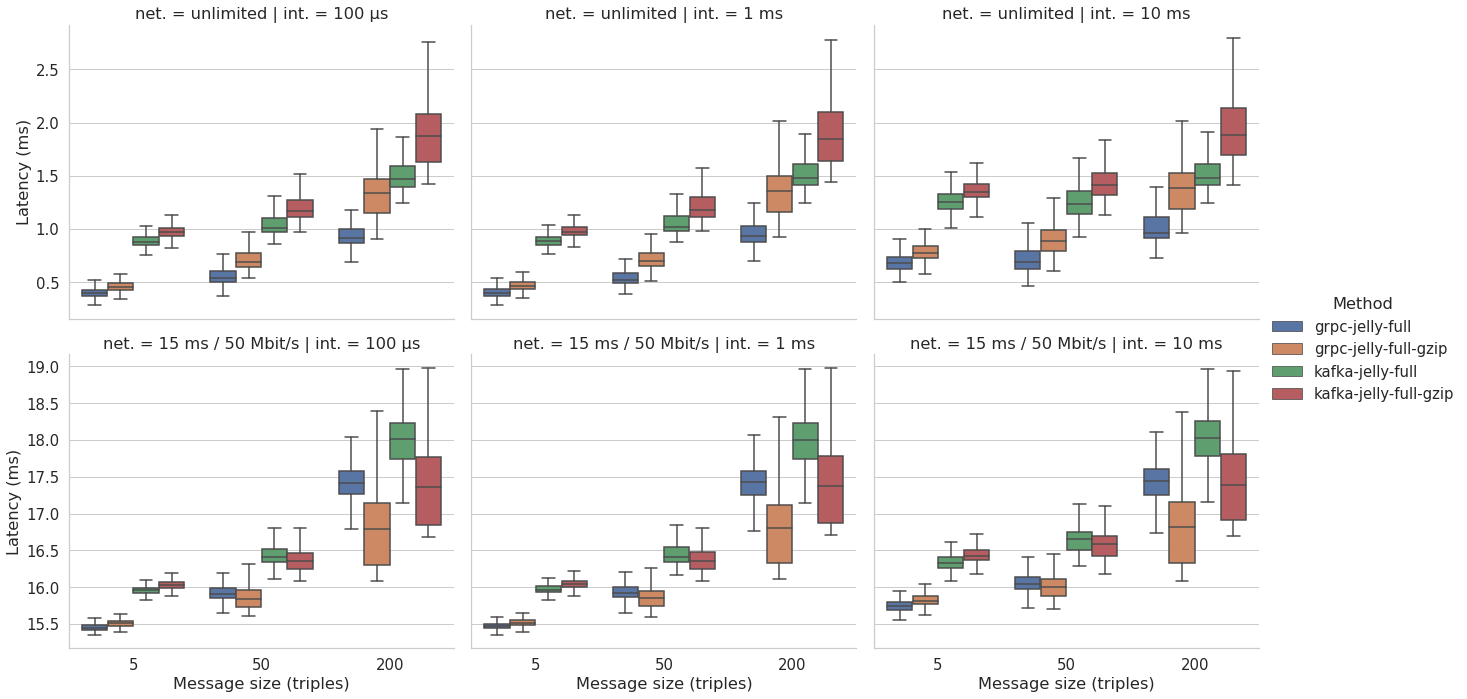

In [23]:
plt.figure(figsize=(10, 10))

dt_vis = dt_exps[dt_exps.method.str.contains('jelly_full') & ~(dt_exps.network == '100Mbit')]\
    [['network', 'interval', 'method', 'mSize', 'latency']]

dt_vis['interval'] = dt_vis['interval'].apply(lambda i: short_times(i))
dt_vis['network'] = dt_vis['network'].apply(lambda n: long_network(n))
dt_vis['method'] = dt_vis['method'].apply(lambda n: n.replace('_', '-'))

dt_vis = dt_vis.rename(columns={'network': 'net.', 'interval': 'int.', 'method': 'Method'})

g = sns.catplot(
    data=dt_vis, x='mSize', y='latency', hue='Method',
    kind='box', row='net.', col='int.', showfliers=False,
    order=['5', '50', '200'],
    sharey='row', aspect=1.2
)

g.set_axis_labels('Message size (triples)', 'Latency (ms)')

plt.savefig('img/latency_gzip.svg')
plt.savefig('img/latency_gzip.eps')

<Figure size 720x360 with 0 Axes>

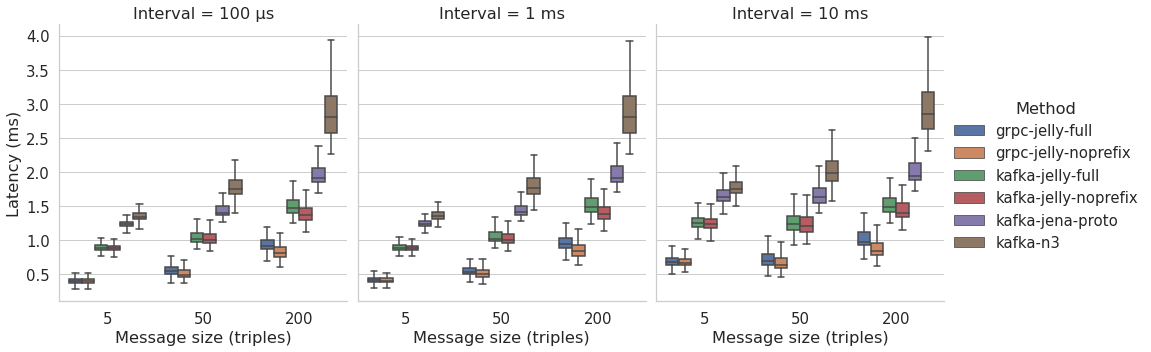

<Figure size 720x360 with 0 Axes>

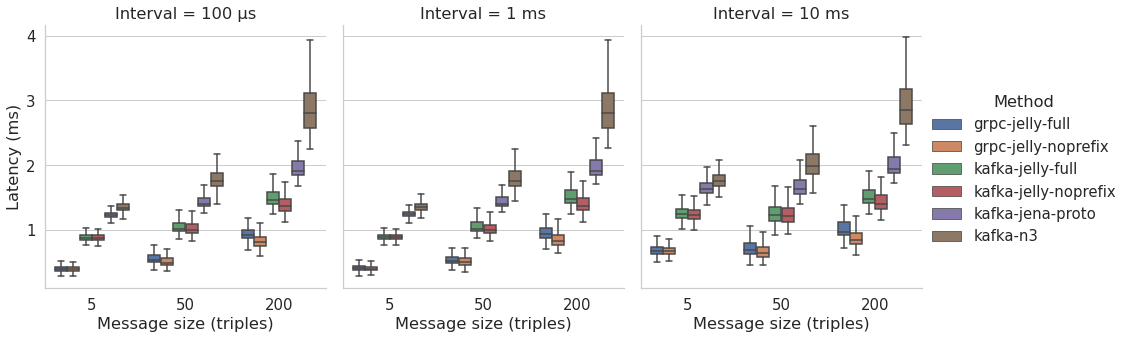

In [24]:
plt.figure(figsize=(10, 5))

dt_vis = dt_exps[~dt_exps.method.str.contains('gzip') & (dt_exps.network == 'unlimited')]\
    [['interval', 'method', 'mSize', 'latency']]

dt_vis['interval'] = dt_vis['interval'].apply(lambda i: short_times(i))
dt_vis['method'] = dt_vis['method'].apply(lambda n: n.replace('_', '-'))

dt_vis = dt_vis.rename(columns={'interval': 'Interval', 'method': 'Method'})

g = sns.catplot(
    data=dt_vis, x='mSize', y='latency', hue='Method',
    kind='box', col='Interval', showfliers=False,
    order=['5', '50', '200'],
    aspect=0.9,
)

g.set_axis_labels('Message size (triples)', 'Latency (ms)')

plt.savefig('img/latency_unl.svg')
plt.savefig('img/latency_unl.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


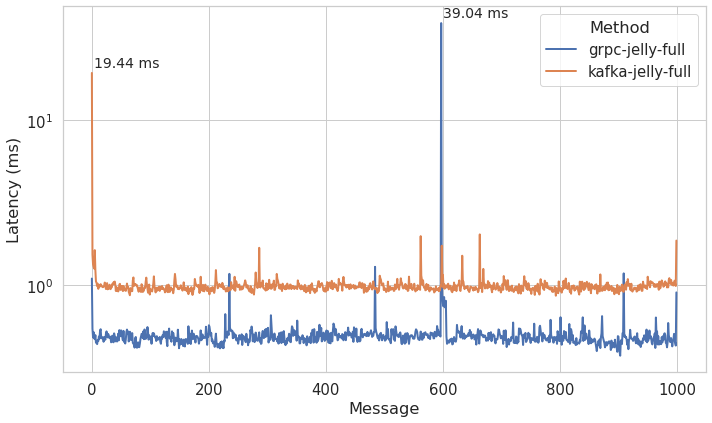

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


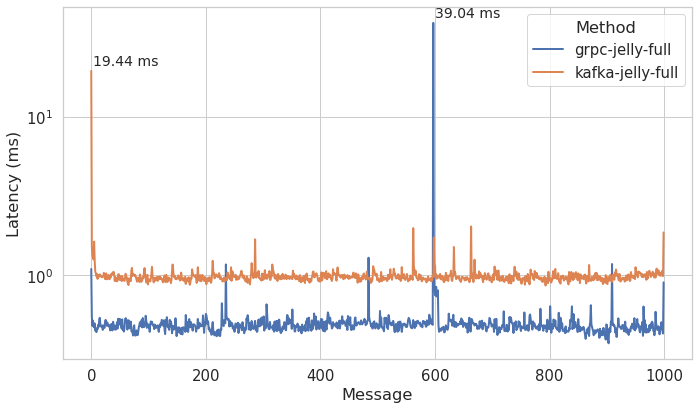

In [25]:
plt.figure(figsize=(10, 6))
dt_plot = dt_exps[(dt_exps.network == 'unlimited') & (dt_exps.interval == '100 microseconds') & (dt_exps.method.str.endswith('jelly_full')) & (dt_exps.mSize == '50') & (dt_exps.dataset == 'aemet-1')]\
    [['method', 'n', 'latency']]
#dt_result = pd.DataFrame(np.stack((d_ex[:, 2], d_kafka[:, 2])).T, columns=('grpc', 'kafka'))

sns.lineplot(data=dt_plot, x='n', y='latency', hue='method', linewidth=2, legend=False)
plt.yscale('log')
plt.xlabel('Message')
plt.ylabel('Latency (ms)')

def ann_max(method: str):
    max_grpc = dt_plot[dt_plot.method == method].sort_values(ascending=False, by='latency').iloc[0]
    plt.annotate(
        str(np.round(max_grpc['latency'], 2)) + ' ms',
        (max_grpc['n'] + 3, max_grpc['latency'] * 1.08),
        size=14
    )

ann_max('grpc_jelly_full')
ann_max('kafka_jelly_full')

plt.legend(
    title='Method',
    labels=['grpc-jelly-full', 'kafka-jelly-full']
)

plt.tight_layout()
plt.savefig('img/series.svg')
plt.savefig('img/series.eps')

<Figure size 2160x2160 with 0 Axes>

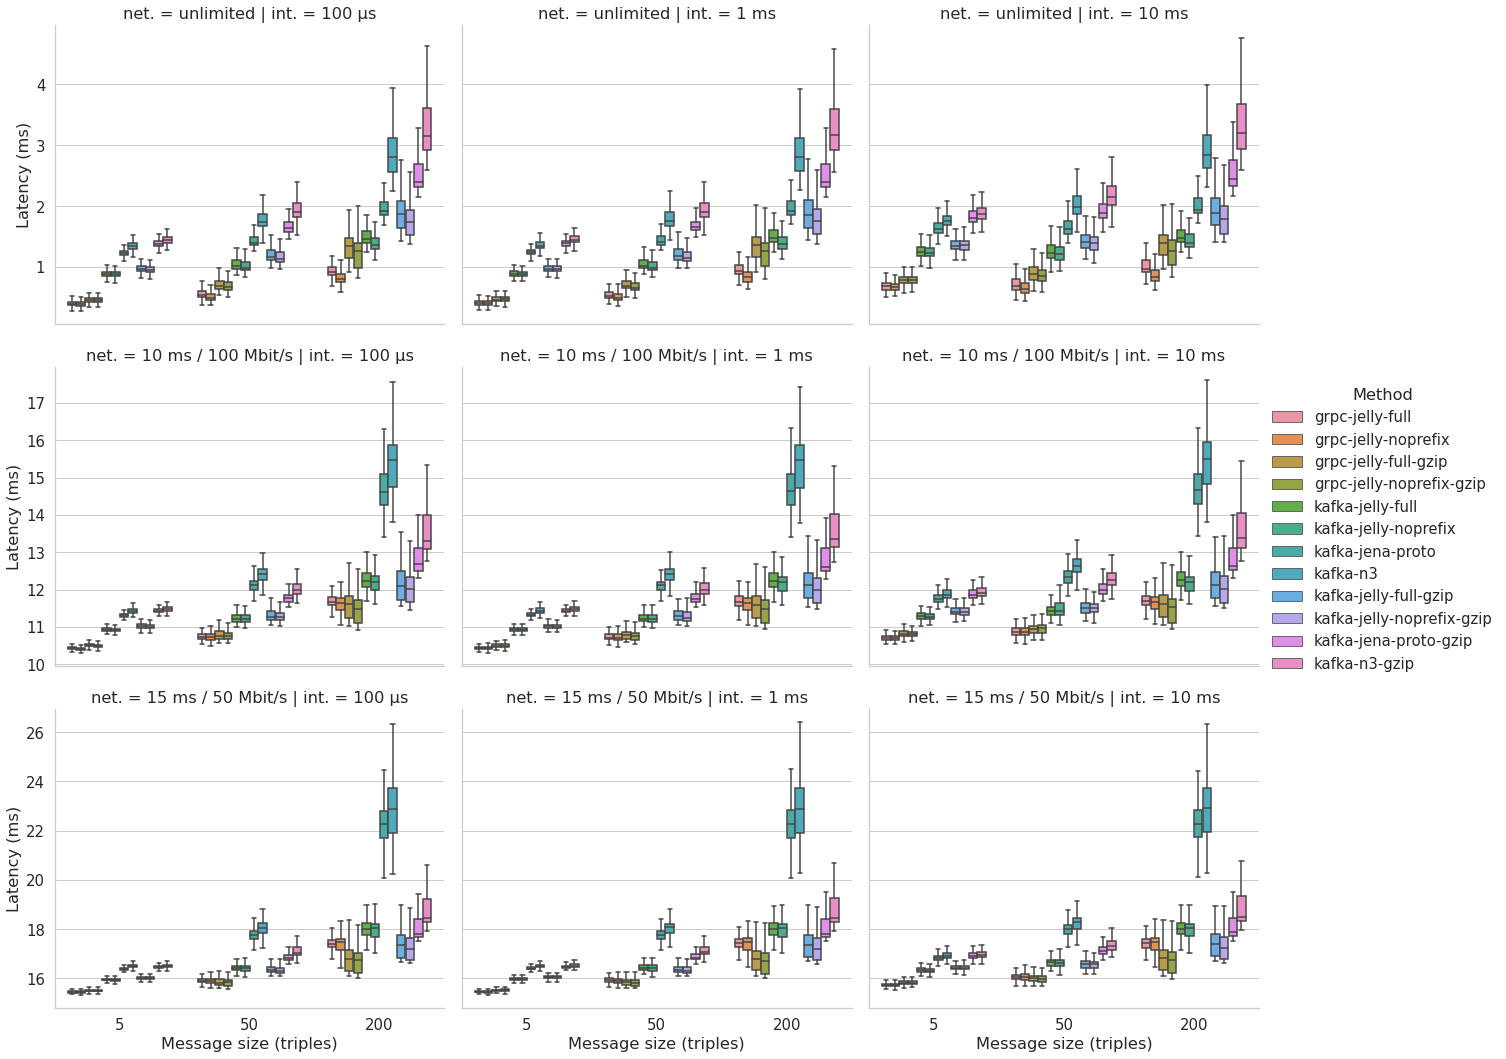

In [34]:
plt.figure(figsize=(30, 30))

dt_vis = dt_exps[['network', 'interval', 'method', 'mSize', 'latency']].copy()

dt_vis['interval'] = dt_vis['interval'].apply(lambda i: short_times(i))
dt_vis['network'] = dt_vis['network'].apply(lambda n: long_network(n))
dt_vis['method'] = dt_vis['method'].apply(lambda n: n.replace('_', '-'))

dt_vis = dt_vis.rename(columns={'network': 'net.', 'interval': 'int.', 'method': 'Method'})

g = sns.catplot(
    data=dt_vis, x='mSize', y='latency', hue='Method',
    kind='box', row='net.', col='int.', showfliers=False,
    order=['5', '50', '200'],
    sharey='row', aspect=1.2
)

g.set_axis_labels('Message size (triples)', 'Latency (ms)')
plt.savefig('extra/img/latency_all.eps')